In [1]:
!git clone https://github.com/andersparslov/BayesianNN-DQR.git
import os
os.chdir('BayesianNN-DQR')

from DQR.models import convLstm, joint_convLstm, joint_tilted_loss, tilted_loss, mse_loss
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import math
tfd = tfp.distributions
tfb = tfp.bijectors
from datetime import datetime
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error as eval_mae
from sklearn.metrics import mean_squared_error as eval_mse
os.chdir('..')

Cloning into 'BayesianNN-DQR'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 1738 (delta 68), reused 0 (delta 0), pack-reused 1637
Receiving objects: 100% (1738/1738), 1.29 GiB | 34.73 MiB/s, done.
Resolving deltas: 100% (481/481), done.
Checking out files: 100% (1142/1142), done.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def sort_and_order(data):
  ## Sort links by order 
  data, order = sort_links(data, '1973:1412', '7057:7058')
  ## Make a link order column e.g here the neighbouring links for link 1 are 0 and 2.
  data.loc[:,'link_order'] = data['link_ref'].astype('category')
  not_in_list = data['link_order'].cat.categories.difference(order)
  data.loc[:,'link_order'] = data['link_order'].cat.set_categories(np.hstack((order, not_in_list)), ordered=True)
  data.loc[:,'link_order'] = data['link_order'].cat.codes
  ## Add week of day column [Monday, ..., Sunday] = [0, ..., 6]
  data.loc[:, 'Weekday'] = data.index.weekday
  ## Add hour of the time to dataframe
  data.loc[:, 'Hour'] = data.index.hour
  ## Add time of day variables to data frame
  data.loc[:, 'TOD'] = data.Hour.apply(tod_interval)
  data = data.sort_values('link_order')
  return data, order

def skip_row(index, keep_list):
	if (index == 0):
		return False ## Never want to skip the header
	return index not in keep_list

def write_3d(X, filename):
  X_list = X.tolist()
  with open(filename+'.csv', 'w', newline='') as csvfile:
      writer = csv.writer(csvfile, delimiter=',')
      writer.writerows(X_list)

def skip_row(index, keep_list):
	if (index == 0):
		return False ## Never want to skip the header
	return index not in keep_list

def transform(data, means_df, scales_df, order, freq = '15min'):
  tss = { }
  ws = { }
  removed_mean = { }
  removed_scale = { }
  lnk_list = []
  for lnk, data_link in data.groupby('link_ref', sort = False):
    # Link Data Time Indexed
    link_time_ix = pd.DatetimeIndex(data_link.index)
    data_link = data_link.set_index(link_time_ix)
    # Link Reference Data Index
    ix_week = data_link['Weekday'].tolist()
    ix_tod = data_link['TOD'].tolist()
    ## Create multi index for the two lists
    mult_ind = pd.MultiIndex.from_arrays([ix_week, ix_tod])

    link_travel_time_k = data_link['link_travel_time'].resample(freq).mean()
    removed_mean[lnk] = pd.Series(data=means_df[lnk].loc[mult_ind].values, 
                                  index = link_time_ix).resample(freq).mean()
    removed_scale[lnk] = pd.Series(data =scales_df[lnk].loc[mult_ind].values, 
                                    index = link_time_ix).resample(freq).mean()
    tss[lnk] = (link_travel_time_k - removed_mean[lnk].values) / removed_scale[lnk].values
    ws[lnk] = data_link['link_travel_time'].resample(freq).count()
    lnk_list.append(lnk)

  ts = pd.DataFrame(data = tss).replace([np.inf, -np.inf], np.nan).fillna(method='pad').fillna(0) 
  df_removed_mean = pd.DataFrame(data = removed_mean, index = ts.index).fillna(method='pad').fillna(method='bfill') 
  df_removed_scale = pd.DataFrame(data = removed_scale, index = ts.index).fillna(method='pad').fillna(method='bfill')    
  w = pd.DataFrame(data = ws).fillna(0) # Link Travel Time Weights, e.g. number of measurements
  return ts[order], df_removed_mean[order], df_removed_scale[order]

def fit_scale(data, order, ref_freq = '15min'):
  means = { }
  scales = { }
  low = { }
  upr = { }

  grouping = data[data['link_travel_time'].notnull()].groupby('link_ref', sort = False)
  for link_ref, data_link in grouping:
      # Fit outlier bounds using MAD
      median = data_link.groupby('Weekday')['link_travel_time'].median()
      error = pd.concat([data_link['Weekday'], np.abs(data_link['link_travel_time'] - median[data_link['Weekday']].values)], axis = 1)
      mad = 1.4826 * error.groupby('Weekday')['link_travel_time'].median()
      _low = median - 3 * mad
      _upr = median + 3 * mad
      mask = (_low[data_link['Weekday']].values < data_link['link_travel_time'])&(data_link['link_travel_time'] < _upr[data_link['Weekday']].values)
      data_link_no = data_link[mask]
      _mean = data_link_no.groupby(['Weekday', 'TOD'])['link_travel_time'].mean()
      means[link_ref] = _mean
      scale = data_link_no.groupby(['Weekday', 'TOD'])['link_travel_time'].std()
      scales[link_ref] = scale

      low[link_ref] = _low
      upr[link_ref] = _upr

  means_df = pd.DataFrame(data=means).interpolate()
  scales_df = pd.DataFrame(data=scales).interpolate()
  low_df = pd.DataFrame(data=low).interpolate()
  upr_df = pd.DataFrame(data=upr).interpolate()

  ## Correct order of links
  means_df = means_df[order]
  scales_df = scales_df[order]
  low_df = low_df[order]
  upr_df = upr_df[order]

  # Fill NaNs    
  means_df = means_df.fillna(method='pad').fillna(method='bfill')
  scales_df = scales_df.fillna(method='pad').fillna(method='bfill')
  low_df = low_df.fillna(method='pad').fillna(method='bfill')
  upr_df = upr_df.fillna(method='pad').fillna(method='bfill')
  
  return means_df, scales_df

def roll(ix, ts, removed_mean, removed_scale, lags, preds):
  X = np.stack([np.roll(ts, i, axis = 0) for i in range(lags, 0, -1)], axis = 1)[lags:-preds,]
  Y = np.stack([np.roll(ts, -i, axis = 0) for i in range(0, preds, 1)], axis = 1)[lags:-preds,]
  Y_ix = ix[lags:-preds]
  Y_mean = np.stack([np.roll(removed_mean, -i, axis = 0) for i in range(0, preds, 1)], axis = 1)[lags:-preds,]
  Y_scale = np.stack([np.roll(removed_scale, -i, axis = 0) for i in range(0, preds, 1)], axis = 1)[lags:-preds,]
  return X, Y, Y_ix, Y_mean, Y_scale

def sort_links(data, start_link, end_link):
  ordered_list = [start_link]
  links = data.loc[:,'link_ref'].unique()
  stop_end = start_link.rpartition(':')[2]
  while True:
      stop_start = stop_end
      for lnk in links:
          if(lnk.rpartition(':')[0] == stop_start):
              if( (lnk in ordered_list) or (lnk == end_link) ):
                  break
              else:
                  ordered_list.append(lnk)
                  stop_end = lnk.rpartition(':')[2]
      if(stop_start == stop_end):
          break
  ordered_list.append(end_link)
  ## Only include links in ordered list.
  data = data[data.loc[:,'link_ref'].isin(ordered_list)]
  return data, ordered_list

def tod_interval(x):
  if(x < 2):
      return 0
  elif(x < 4):
      return 1
  elif(x < 6):
      return 2
  elif(x < 8):
      return 3
  elif(x < 10):
      return 4
  elif(x < 12):
      return 5
  elif(x < 14):
      return 6
  elif(x < 16):
      return 7
  elif(x < 18):
      return 8
  elif(x < 20):
      return 9
  elif(x < 22):
      return 10
  elif(x < 24):
      return 11

def split_df(data, start_train, end_train, end_test):
  data_train = data.loc[start_train:end_train]
  data_test = data.loc[end_train:end_test]
  return data_train, data_test

def split_df_with_val(data, start_train, end_train, end_val, end_test):
  data_train = data.loc[start_train:end_train]
  data_val = data.loc[end_train:end_val]
  data_test = data.loc[end_val:end_test]
  return data_train, data_val, data_test

def drop_remainder(X, y, y_ix, y_mean, y_std, drop):
  return X[:-drop], y[:-drop], y_ix[:-drop], y_mean[:-drop], y_std[:-drop]

def tilted_loss_np_t(q, y, f):
  e = y-f
  # The term inside k.mean is a one line simplification of the first equation
  return np.mean(np.maximum(q*e, (q-1)*e))

In the Notebook "Pre-trained Weight Prediction" we selected independent mean models, independent quantile models and joint models based on a parameter grid-search. 

# Lag 10 Model Parameters

In [0]:
## Mean parameters
num_units_mean_l10 = 24
kern_mean_l10 = 11
## Quantile
num_units_quan_l10 = 18
kern_quan_l10 = 3
## Joint
num_units_joint_l10 = 12
kern_joint_l10 = 10

# Lag 32 Model Parameters

In [0]:
## Mean parameters
num_units_mean_l32 = 9
kern_mean_l32 = 11
## Quantile
num_units_quan_l32 = 24
kern_quan_l32 = 10
## Joint
num_units_joint_l32 = 42
kern_joint_l32 = 3

In [0]:
mtypes = ['Joint']#, 'Joint', 'Independent', 'Independent', 'Naive'] 
lag_lst = [10]#, 32, 10, 32]
models = [joint_convLstm]#,  joint_convLstm,convLstm, convLstm]

param_mean_l10 = [num_units_mean_l10, kern_mean_l10]
param_mean_l32 = [num_units_mean_l32, kern_mean_l32]
param_quan_l10 = [num_units_quan_l10, kern_quan_l10]
param_quan_l32 = [num_units_quan_l32, kern_quan_l32]
param_joint_l10 = [num_units_joint_l10, kern_joint_l10]
param_joint_l32 = [num_units_joint_l32, kern_joint_l32]
param_lst = [param_joint_l10,                 ## Joint lag-10 parameters
             param_joint_l32,                 ## Joint lag-32 parameters
             [param_mean_l10, param_quan_l10], ## Independent lag-10 parameters
             [param_mean_l32, param_quan_l32], ## Independent lag-32 parameters
             None] 
epochs = 200
batch_size = 80
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

In [0]:
start = datetime.strptime('19/01/21', "%y/%m/%d")
end   = datetime.strptime('19/04/14', "%y/%m/%d")
period = (end - start).days
period_train_days = 7*4   ## Train on 4 weeks
period_val_days = 7       ## Validate training on 1 week
period_test_days = 7*1    ## Test on  1 week
advance_days = 7*1        ## Advance by 1 week
num_partitions = int((period-period_train_days-period_test_days)/advance_days)

prob = 0.2
preds = 3 
quantiles = np.array([0.025, 0.975, 0.05, 0.95]) 
pred_ints = np.array([0.95,         0.90])
num_links = 16

mse = np.empty((preds, num_partitions, len(mtypes)))
mae = np.empty((preds, num_partitions, len(mtypes)))
mape = np.empty((preds, num_partitions, len(mtypes)))
icp = np.empty((preds, int(len(quantiles)/2), num_partitions, len(mtypes)))
mil = np.empty((preds, int(len(quantiles)/2), num_partitions, len(mtypes)))
tradeoff = np.empty((preds, int(len(quantiles)/2), num_partitions, len(mtypes)))
tilt_loss = np.empty((preds, len(quantiles), num_partitions, len(mtypes)))

icp_route = np.empty((preds, int(len(quantiles)/2), num_partitions, len(mtypes)))
mil_route = np.empty((preds, int(len(quantiles)/2), num_partitions, len(mtypes)))
tradeoff_route = np.empty((preds, int(len(quantiles)/2), num_partitions, len(mtypes)))
mse_route = np.empty((preds, num_partitions, len(mtypes)))
mae_route = np.empty((preds, num_partitions, len(mtypes)))
mape_route = np.empty((preds, num_partitions, len(mtypes)))

time = np.empty((num_partitions, len(mtypes)))

In [12]:
for m, (mtype, param, lags) in enumerate(zip(mtypes, param_lst, lag_lst)):
  if mtype == 'Independent' or mtype == 'Joint':
    print("{} ConvLSTM DQR with {} lags, ".format(mtype, lags), end='')
    ## Get selected model parameters
    net_func = convLstm if mtype == 'Independent' else joint_convLstm
    if mtype == 'Joint':
      units = param[0]
      kern = param[1]
    elif mtype == 'Independent':
      num_units_mean = param[0][0]
      num_units_quan = param[1][0]
      units = [num_units_mean, num_units_quan]
      kern_mean = param[0][1]
      kern_quan = param[1][1]
      kern = [kern_mean, kern_quan]
    print("number units = {} and kernel length = {}".format(units, kern))
  else:
    print("{} (just using historical means)".format(mtype), end='')

  ## Initialise models
  if mtype == 'Joint':
    loss = lambda y, f: joint_tilted_loss(quantiles, y, f)
    net = net_func(units, kern, lags, num_links, preds, quantiles, prob, loss)
  elif mtype == 'Independent':
    net = []
    ## Mean
    loss = 'mse' #lambda y,f: mse_loss(y, f)
    net.append(net_func(units[0], kern[0], lags, num_links, preds, prob, loss))
    ## Quantiles
    for q, quan in enumerate(quantiles):
      loss = lambda y, f: tilted_loss(quan, y, f)
      net.append(net_func(units[1], kern[1], lags, num_links, preds, prob, loss))

  for part in range(num_partitions):
    print("   Partition {}/{}".format(part+1, num_partitions), end=' ')
    train_from = part*advance_days
    train_to = period_train_days + part*advance_days
    val_to = period_train_days + part*advance_days + period_val_days
    test_to = period_train_days + period_val_days + part*advance_days + period_test_days

    train_ind = np.arange(train_from, train_to)
    val_ind = np.arange(train_to, val_to)
    test_ind = np.arange(val_to, test_to)
    print("Training on weeks {}".format(np.arange(int((train_ind[6]+1)/7),
                                                  int((train_ind[-1]+1)/7)+1)), end=' ')
    print("validating training on week {}".format(int((val_ind[-1]+1)/7)))
    keep_train = range(int(2297920*train_ind[ 0]/period), int(2297920*train_ind[-1]/period))
    keep_val = range(int(2297920*train_ind[-1]/period)+1, int(2297920*val_ind[-1]/period))
    keep_test = range(int(2297920*val_ind[-1]/period)+1, int(2297920*test_ind[-1]/period))

    ## Load the part of the dataset we need for training, validation, testing
    data_train = pd.read_csv('BayesianNN-DQR/data/link_travel_time_local.csv.gz', compression='gzip', 
                              parse_dates = True, index_col = 0,
                              skiprows = lambda x: skip_row(x, keep_train))
    data_val = pd.read_csv('BayesianNN-DQR/data/link_travel_time_local.csv.gz', compression='gzip', 
                              parse_dates = True, index_col = 0,
								              skiprows = lambda x: skip_row(x, keep_val))
    data_test  = pd.read_csv('BayesianNN-DQR/data/link_travel_time_local.csv.gz', compression='gzip',
                              parse_dates = True, index_col = 0,
                              skiprows = lambda x: skip_row(x, keep_test))
    ## Sort data by links and add categorical columns TOD, Weekday
    data_train, order = sort_and_order(data_train)
    data_val, order = sort_and_order(data_val)
    data_test, order = sort_and_order(data_test)
    
    ## Transform datasets using the mean and std for train and val set.
    means_df_train, scales_df_train = fit_scale(pd.concat([data_train,data_val]), order)
    ts_train_df, mean_train_df, scale_train_df = transform(data_train, 
                                                            means_df_train, 
                                                            scales_df_train, 
                                                            order,
                                                            freq = '15min')
    ts_val_df, mean_val_df, scale_val_df = transform(data_val, 
                                                      means_df_train, 
                                                      scales_df_train, 
                                                      order,
                                                      freq = '15min')
    ts_test_df, mean_test_df, scale_test_df = transform(data_test, 
                                                        means_df_train, 
                                                        scales_df_train, 
                                                        order,
                                                        freq = '15min')
    ## Roll data into timeseries format
    X_train, y_train, y_ix_train, y_mean_train, y_std_train = roll(ts_train_df.index, 
                                                                    ts_train_df.values,
                                                                    mean_train_df.values,
                                                                    scale_train_df.values,
                                                                    lags, 
                                                                    preds)
    X_val, y_val, y_ix_val, y_mean_val, y_std_val = roll(ts_val_df.index, 
                                                        ts_val_df.values,
                                                        mean_val_df.values,
                                                        scale_val_df.values,
                                                        lags, 
                                                        preds)
    X_test, y_test, y_ix_test, y_mean_test, y_std_test = roll(ts_test_df.index, 
                                                              ts_test_df.values, 
                                                              mean_test_df.values,
                                                              scale_test_df.values,
                                                              lags, 
                                                              preds)
    ## Get extra dimensions for proper tensor format
    X_train = X_train[:,:,:,np.newaxis, np.newaxis]
    X_val = X_val[:,:,:,np.newaxis, np.newaxis]
    X_test = X_test[:,:,:,np.newaxis, np.newaxis]
    y_train = y_train[:,:,:,np.newaxis, np.newaxis]
    y_val = y_val[:,:,:,np.newaxis, np.newaxis]
    y_test = y_test[:,:,:,np.newaxis, np.newaxis]

    ## To be used for joint (last dimension is for mean, q1, ..., qJ)
    y_traink = np.zeros((y_train.shape[0], y_train.shape[1], y_train.shape[2], 1, len(quantiles)+1))
    y_testk  = np.zeros((y_test.shape[0], y_train.shape[1], y_train.shape[2], 1, len(quantiles)+1))
    y_valk  = np.zeros((y_val.shape[0], y_train.shape[1], y_train.shape[2], 1, len(quantiles)+1))
    for i in range(len(quantiles)+1):
      y_traink[:,:,:,:,i] = y_train[:,:,:,:,0]
      y_valk[:,:,:,:,i] = y_val[:,:,:,:,0]
      y_testk[:,:,:,:,i] = y_test[:,:,:,:,0]

    if mtype == "Independent":
      check_mean = ModelCheckpoint("/content/gdrive/My Drive/ModelCheckpoint/check_mean.hdf5", 
                                 monitor='val_loss', mode='min', save_best_only=True)
      check_q = []
      for q, quan in enumerate(quantiles):
        check_q.append(ModelCheckpoint("/content/gdrive/My Drive/ModelCheckpoint/check_q{}.hdf5".format(q), 
                                       monitor='val_loss', mode='min', save_best_only=True))
        
      ############################## INDEPENDENT ###############################
      ## If not the first partition initialise weights from last partition
      if part > 0:
        net[0].load_weights("/content/gdrive/My Drive/ModelCheckpoint/check_mean.hdf5")
        for q, quan in enumerate(quantiles):
          net[q+1].load_weights("/content/gdrive/My Drive/ModelCheckpoint/check_q{}.hdf5".format(q))
      t1 = datetime.now()
      net[0].fit(X_train, y_train, 
                 epochs = epochs,
                 validation_data = (X_val, y_val),
                 batch_size = batch_size, 
                 callbacks = [es, check_mean],verbose=1)
      net[0].load_weights("/content/gdrive/My Drive/ModelCheckpoint/check_mean.hdf5")
      for q in range(len(quantiles)):
        net[q+1].fit(X_train, y_train, 
                epochs=epochs,
                validation_data=(X_val, y_val),
                batch_size=batch_size,
                callbacks=[es, check_q[q]],verbose = 0)
        net[q+1].load_weights("/content/gdrive/My Drive/ModelCheckpoint/check_q{}.hdf5".format(q))
      t2 = datetime.now()
      y_pred_q = []
      for q in range(len(quantiles)):
        y_pred_q.append(net[q+1].predict(X_test))
    elif mtype == 'Joint':
      check_joint = ModelCheckpoint("/content/gdrive/My Drive/ModelCheckpoint/check_joint.hdf5", 
                                    monitor='val_loss', mode='min', save_best_only=True)
      ################################## JOINT #################################
      t1 = datetime.now()
      net.fit(X_train,y_traink, 
              epochs = epochs, validation_data = (X_val, y_valk),
              batch_size = batch_size, callbacks=[es, check_joint], verbose=0)
      net.load_weights("/content/gdrive/My Drive/ModelCheckpoint/check_joint.hdf5")
      t2 = datetime.now()
    ## Save time to fit
    time[part, m] = (t2-t1).seconds

    if mtype == 'Independent' or mtype == 'Joint':
      print("  Testing on week {}".format(int((test_ind[-1]+1)/7)))
      if mtype == 'Joint':
        y_pred = net.predict(X_test)
      else:
        y_pred = net[0].predict(X_test)
      ## Back-transform using respective scales and means
      y_pred_back = y_pred[:,:,:,0,0]*y_std_test + y_mean_test
    ## The naive approach is just to predict using group means
    else:
      y_pred_back = y_mean_test
    ## Evaluate model
    for t in range(preds): 
      y_pred_t_all = np.sum(y_pred_back[:,t],axis=1)
      y_true_t = y_test[:,t,:,0,0]*y_std_test[:,t,:] + y_mean_test[:,t,:]
      y_true_t_all = np.sum(y_true_t, axis=1)
      if mtype == 'Independent' or mtype == 'Joint':
        for i in range(int(len(quantiles)/2)):
          icp_lnks = np.zeros(num_links)
          mil_lnks = np.zeros(num_links)  
          tradeoff_lnks = np.zeros(num_links)
          for lnk in range(num_links):
            if mtype == 'Independent':
              q1 = y_pred_q[2*i][:,t,lnk,0,0]*y_std_test[:,t,lnk] + y_mean_test[:,t,lnk]
              q2 = y_pred_q[2*i+1][:,t,lnk,0,0]*y_std_test[:,t,lnk] + y_mean_test[:,t,lnk]
            else:
              q1 = y_pred[:,t,lnk,0,2*i+1]*y_std_test[:,t,lnk] + y_mean_test[:,t,lnk]
              q2 = y_pred[:,t,lnk,0,2*i+2]*y_std_test[:,t,lnk] + y_mean_test[:,t,lnk]
            y_lnk_t = y_true_t[:,lnk]
            icp_lnks[lnk] = 1-(np.sum(y_lnk_t < q1) + np.sum(y_lnk_t > q2))/len(y_test)
            mil_lnks[lnk] = np.sum(np.maximum(0, q2 - q1)) / len(y_test)
            tradeoff_lnks[lnk] = np.abs(icp_lnks[lnk] - pred_ints[i])*mil_lnks[lnk]
          icp[t, i, part, m] = np.mean(icp_lnks)
          mil[t, i, part, m] = np.mean(mil_lnks)
          tradeoff[t, i, part, m] = np.mean(tradeoff_lnks)
      mse_lnks = np.zeros(num_links)
      mae_lnks = np.zeros(num_links)  
      mape_lnks = np.zeros(num_links)
      for lnk in range(num_links):
        y_lnk_t = y_true_t[:,lnk]
        y_pred_lnk = y_pred[:,t,lnk,0,0]
        mse_lnks[lnk] = eval_mse(y_pred_lnk/60, y_lnk_t/60)
        mae_lnks[lnk] = eval_mae(y_pred_lnk/60, y_lnk_t/60)
        mape_lnks[lnk] = np.mean(np.abs((y_pred_lnk/60 - y_lnk_t/60)/(y_lnk_t/60)))
      mse[t, part, m] = np.mean(mse_lnks)
      mae[t, part, m] = np.mean(mae_lnks)
      mape[t, part, m] = np.mean(mape_lnks)
      for q, quan in enumerate(quantiles):
          if mtype == 'Independent':
            quan_pred = np.squeeze(y_pred_q[q][:,t])
          else:
            quan_pred = np.squeeze(y_pred[:,t,:,:,2*i+1])
          tilt_loss[t, q, part, m] = tilted_loss_np_t(quan, np.squeeze(y_test[:,t]), quan_pred)
      for i in range(int(len(quantiles)/2)):
        if mtype == 'Independent':
          q1 = y_pred_q[2*i][:,t,:,0,0]*y_std_test[:,t] + y_mean_test[:,t]
          q2 = y_pred_q[2*i+1][:,t,:,0,0]*y_std_test[:,t] + y_mean_test[:,t]
        else:
          q1 = y_pred[:,t,:,0,2*i+1]*y_std_test[:,t] + y_mean_test[:,t]
          q2 = y_pred[:,t,:,0,2*i+2]*y_std_test[:,t] + y_mean_test[:,t]
        q1_all = np.sum(q1, axis=1)#*y_std_test[:,t] + y_mean_test[:,t]
        q2_all = np.sum(q2, axis=1)#*y_std_test[:,t] + y_mean_test[:,t]
        icp_route[t, i, part, m] = 1-(np.sum(y_true_t_all < q1_all)+np.sum(y_true_t_all > q2_all))/len(y_test)
        mil_route[t, i, part, m] = np.sum(np.maximum(0, q2_all - q1_all)) / len(y_test)
        tradeoff_route[t, i, part, m] = np.abs(icp_route[t, i, part, m] - pred_ints[i])*mil_route[t, i, part, m]
          

      mse_route[t, part, m] = eval_mse(y_pred_t_all/60, y_true_t_all/60)
      mape_route[t, part, m] = np.mean(np.abs((y_pred_t_all - y_true_t_all) / y_true_t_all))
      mae_route[t, part, m] = eval_mae(y_pred_t_all, y_true_t_all)

    ## Print results
    for t in range(preds):
      print("   Timestep t + {}".format(t+1))
      if mtype == 'Joint' or mtype == 'Independent':
        print("    Quantile errors (avg )  ICP (0.95) %.2f, MIL (0.95) %.2f, ICP (0.90) %.2f, MIL (0.90) %.2f" % (icp[t,0,part,m], mil[t,0,part,m], icp[t,1,part,m], mil[t,1,part,m]))
        print("    Quantile errors (route) ICP (0.95) %.2f, MIL (0.95) %.2f, ICP (0.90) %.2f, MIL (0.90) %.2f" % (icp_route[t,0,part,m], mil_route[t,0,part,m], icp_route[t,1,part,m], mil_route[t,1,part,m]))
        print(" Tilted loss for quantile:", end='')
        for q, quan in enumerate(quantiles):
          print(" {} ".format(quan), end='')
          print("%.2f " % tilt_loss[t,q,part,m], end = '')
        print("")
      print("    Mean errors (avg )  MSE %.2f MAE %.2f MAPE %.2f" % (mse[t,part,m], mae[t,part,m], mape[t,part,m]))
      print("    Mean errors (route) MSE %.2f MAE %.2f MAPE %.2f" % (mse_route[t,part,m], mae_route[t,part,m], mape_route[t,part,m]))
  print(" - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  -- - - - - - - - - - -  - ")

Joint ConvLSTM DQR with 10 lags, number units = 12 and kernel length = 10
   Partition 1/6 Training on weeks [1 2 3 4] validating training on week 5
Epoch 00032: early stopping
  Testing on week 6
   Timestep t + 1
    Quantile errors (avg )  ICP (0.95) 0.94, MIL (0.95) 55.25, ICP (0.90) 0.88, MIL (0.90) 42.81
    Quantile errors (route) ICP (0.95) 1.00, MIL (0.95) 884.06, ICP (0.90) 1.00, MIL (0.90) 685.00
 Tilted loss for quantile: 0.025 0.05  0.975 1.27  0.05 0.08  0.95 1.24 
    Mean errors (avg )  MSE 2.01 MAE 1.31 MAPE 1.00
    Mean errors (route) MSE 1.56 MAE 56.49 MAPE 0.04
   Timestep t + 2
    Quantile errors (avg )  ICP (0.95) 0.94, MIL (0.95) 55.72, ICP (0.90) 0.87, MIL (0.90) 42.70
    Quantile errors (route) ICP (0.95) 1.00, MIL (0.95) 891.57, ICP (0.90) 1.00, MIL (0.90) 683.22
 Tilted loss for quantile: 0.025 0.05  0.975 1.24  0.05 0.08  0.95 1.21 
    Mean errors (avg )  MSE 2.01 MAE 1.31 MAPE 1.00
    Mean errors (route) MSE 1.87 MAE 61.00 MAPE 0.05
   Timestep t + 3
 

In [29]:
print("%.3f" % (100*np.mean(mape_route[2])))

5.599


In [20]:
np.mean(time[1:])

118.2

In [0]:
for m, mod in enumerate(mtypes):
  print(mod)
  print(" Time to train", time[0,m])
  print(" Avg retrain time", np.mean(time[1:,m]))
  for t in range(preds):
    print(" t + {}".format(t+1))
    print("  Avg MSE (within links) ()", np.mean(mse[t,:,m]))
    print("  Avg MAE (within links) ()", np.mean(mae[t,:,m]))
    print("  Avg MAPE (within links) ()", np.mean(mape[t,:,m]))
    print("  Avg MSE (route) ()", np.mean(mse_route[t,:,m]))
    print("  Avg MAE (route) ()", np.mean(mae_route[t,:,m]))
    print("  Avg MAPE (route) ()", np.mean(mape_route[t,:,m]))

    for i in range(int(len(quantiles)/2)):
      print("  Prediction interval: ", pred_ints[i])
      print("    Avg ICP (within links)", np.mean(icp[t, i, :, m]))
      print("    Avg MIL (within links)", np.mean(mil[t, i, :, m]))
      print("    Avg Tradeoff (within links)", np.mean(tradeoff[t, i, :, m]))
      print("    Avg ICP (route)", np.mean(icp_route[t, i, :, m]))
      print("    Avg MIL (route)", np.mean(mil_route[t, i, :, m]))
      print("    Avg Tradeoff (route)", np.mean(tradeoff_route[t, i, :, m]))

  print("\n")

In [30]:
y_pred.shape

(1019, 3, 16, 1, 5)

Text(0.5, 0, 'Date (Year-Month-Day)')

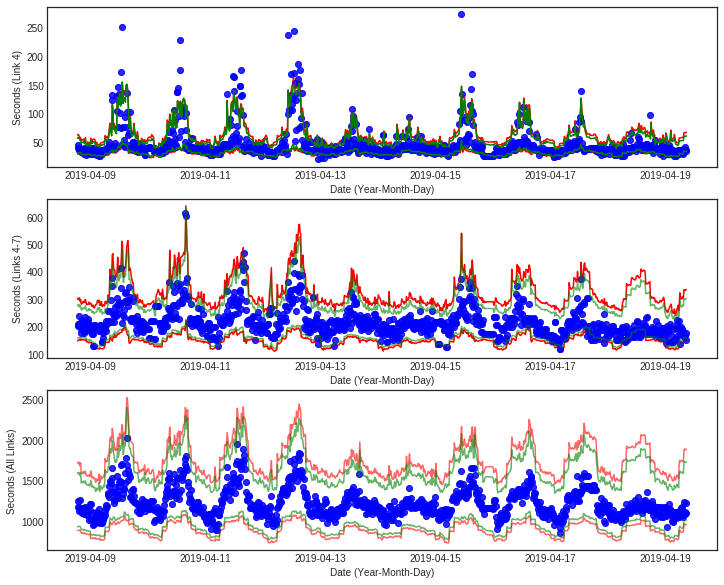

In [73]:
plt.style.use('seaborn-white')

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), gridspec_kw={'width_ratios':[1.7]})

ax1.plot(y_ix_test, y_test[:,0,3,0,0]*y_std_test[:,0,3]+ y_mean_test[:,0,3], 'bo', alpha = 0.6)
ax1.plot(y_ix_test, y_pred[:,0,3,0,1]*y_std_test[:,0,3]+ y_mean_test[:,0,3], 'r-')
ax1.plot(y_ix_test, y_pred[:,0,3,0,2]*y_std_test[:,0,3]+ y_mean_test[:,0,3], 'r-')

ax1.plot(y_ix_test, y_test[:,0,3,0,0]*y_std_test[:,0,3]+ y_mean_test[:,0,3], 'bo', alpha = 0.6)
ax1.plot(y_ix_test, y_pred[:,0,3,0,3]*y_std_test[:,0,3]+ y_mean_test[:,0,3], 'g-')
ax1.plot(y_ix_test, y_pred[:,0,3,0,4]*y_std_test[:,0,3]+ y_mean_test[:,0,3], 'g-')

ax1.set_ylabel('Seconds (Link 4)')
ax1.set_xlabel('Date (Year-Month-Day)')

ax2.plot(y_ix_test, np.sum(y_test[:,0,4:7,0,0]*y_std_test[:,0,4:7]+ y_mean_test[:,0,4:7], axis=1), 'bo', alpha = 0.6)
ax2.plot(y_ix_test, np.sum(y_pred[:,0,4:7,0,1]*y_std_test[:,0,4:7]+ y_mean_test[:,0,4:7], axis=1), 'r-')
ax2.plot(y_ix_test, np.sum(y_pred[:,0,4:7,0,2]*y_std_test[:,0,4:7]+ y_mean_test[:,0,4:7], axis=1), 'r-')

ax2.plot(y_ix_test, np.sum(y_test[:,0,4:7,0,0]*y_std_test[:,0,4:7]+ y_mean_test[:,0,4:7], axis=1), 'bo', alpha = 0.6)
ax2.plot(y_ix_test, np.sum(y_pred[:,0,4:7,0,3]*y_std_test[:,0,4:7]+ y_mean_test[:,0,4:7], axis=1), 'g-', alpha = 0.6)
ax2.plot(y_ix_test, np.sum(y_pred[:,0,4:7,0,4]*y_std_test[:,0,4:7]+ y_mean_test[:,0,4:7], axis=1), 'g-', alpha = 0.6)

ax2.set_ylabel('Seconds (Links 4-7)')
ax2.set_xlabel('Date (Year-Month-Day)')

ax3.plot(y_ix_test, np.sum(y_test[:,0,:,0,0]*y_std_test[:,0,:]+ y_mean_test[:,0,:], axis=1), 'bo', alpha = 0.6)
ax3.plot(y_ix_test, np.sum(y_pred[:,0,:,0,1]*y_std_test[:,0,:]+ y_mean_test[:,0,:], axis=1), 'r-', alpha = 0.6)
ax3.plot(y_ix_test, np.sum(y_pred[:,0,:,0,2]*y_std_test[:,0,:]+ y_mean_test[:,0,:], axis=1), 'r-', alpha = 0.6)

ax3.plot(y_ix_test, np.sum(y_test[:,0,:,0,0]*y_std_test[:,0,:]+ y_mean_test[:,0,:], axis=1), 'bo', alpha = 0.6)
ax3.plot(y_ix_test, np.sum(y_pred[:,0,:,0,3]*y_std_test[:,0,:]+ y_mean_test[:,0,:], axis=1), 'g-', alpha = 0.6)
ax3.plot(y_ix_test, np.sum(y_pred[:,0,:,0,4]*y_std_test[:,0,:]+ y_mean_test[:,0,:], axis=1), 'g-', alpha = 0.6)
ax3.set_ylabel('Seconds (All Links)')
ax3.set_xlabel('Date (Year-Month-Day)')

Text(0.5, 0, 'Seconds (Link 4)')

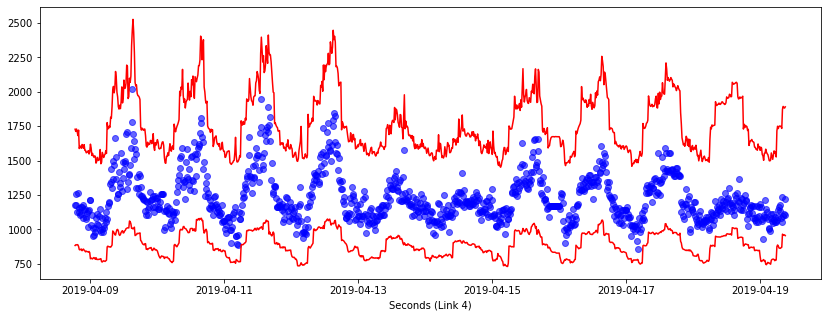

In [52]:
plt.figure(figsize = (14, 5))
plt.plot(y_ix_test, np.sum(y_test[:,0,:,0,0]*y_std_test[:,0,:]+ y_mean_test[:,0,:], axis=1), 'bo', alpha = 0.6)
plt.plot(y_ix_test, np.sum(y_pred[:,0,:,0,1]*y_std_test[:,0,:]+ y_mean_test[:,0,:], axis=1), 'r-')
plt.plot(y_ix_test, np.sum(y_pred[:,0,:,0,2]*y_std_test[:,0,:]+ y_mean_test[:,0,:], axis=1), 'r-')
plt.xlabel('Seconds (Link 4)')